<div align="center">
    <h2>Reinforcement Learning Summer 2024</h2>
    <h2>Prof. Dr. Frank Kirchner</h2>
    <h4>Exercise Sheet – II</h4>
    <h5>Due: 08.05.24</h5>
    <hr>
</div>


# Problem 2.1: Monte Carlo Methods (10 Points)

In this task, you are going to implement Monte Carlo learning for a blackjack environment. The blackjack environment follows these rules:

- The agent and the dealer both get an open card at the start.
- The observation space consists of the value of the dealer and the agent.
- The agent starts by drawing cards or sticking with the current cards (the actions).
- Then the dealer draws cards until he beats or draws the agent or busts (exceeding 21).
- There is no special ace, but the card values 1 and 11.
- The card value from 1 to 9 and 11 each have a chance of $1/14$ and the card value 10 has the chance of $4/14$. The drawing happens with replacement.
- The environment terminates when a game ends, either by the player winning when reaching 21 (reward: $1.5$) or the dealer exceeding 21 (reward: 1),
  the dealer winning by having a higher number than the player or the player busting (both reward: $-1$), or a draw when both have the same value (reward: 0).
- Resetting the environment sets the starting values of the dealer and the player to values between 1 and 11.

For the following tasks hand in the final code after the last task as well as the plot of the last subtask.

1. **(3 Points)** Implement the environment in the cell `2.1a` Black jack. The environment must not be implemented with the gymnasium package but has
   to follow the conventions of their environments (names, methods, returned values, etc.). Rendering is not necessary as the results can be output via the print function.
   Test your implementation thoroughly.
2. **(3 Points)** Implement the First Visit Monte Carlo learning from the lecture in the subsequent `2.1b` cell. We will use the state-action-values for this task and
   you should use the predefined variable for that. Run the learning for different number of episodes until you are happy with the success.
3. **(1 Point)** Implement an automatic_game(number_of_games) function in the cell `2.1c`, that uses the obtained state-action-values to play against the dealer.
4. **(2 Points)** Also implement the every visit MC. Add an attribute in the class initialization method to choose the method.
5. **(1 Point)** Train one first visit and one every visit MC for 1000 episodes. Every 100 episodes play 100 automatic games with the obtained
   action-state-values. Plot the development of the rewards of both versions in two separate graphs.


## 2.1a: Black jack

In [1]:
import numpy as np

class BlackJackEnv:

    def __init__(self):
        # [0]-> Player
        # [1]-> Dealer
        self.observation_space = [0, 0]
        # [0]-> Draw
        # [1]-> Stick
        self.action_space = (0, 1)
        self.rng = np.random.default_rng()


    def sample_action(self):
        return int(self.rng.choice(self.action_space, 1))

    def _get_card(self):
        return int(self.rng.choice((1,2,3,4,5,6,7,8,9,10,10,10,10,11),1))

    def reset(self):
        self.end_flag = False
        self.observation_space = [self._get_card(), self._get_card()]
        return self.observation_space.copy()

    def step(self, action):
        """
        return: observation_space, reward, terminated
        """
        if self.end_flag:
            return self.observation_space, 0, True

        # While the player value is lower than the dealers draw cards for the dealer 
        while(action == 1):
            self.observation_space[1] += self._get_card()
            
            if self.observation_space[1] > 21:
                self.end_flag = True
                return self.observation_space.copy(), 1, True
            elif self.observation_space[1] > self.observation_space[0]:
                self.end_flag = True
                return self.observation_space.copy(), -1, True
            elif self.observation_space[1] == self.observation_space[0]:
                self.end_flag = True
                return self.observation_space.copy(), 0, True

        self.observation_space[0] += self._get_card()
        
        if self.observation_space[0] == 21:
            self.end_flag = True
            return self.observation_space.copy(), 1.5, True
        
        elif self.observation_space[0] > 21:
            self.end_flag = True
            return self.observation_space.copy(), -1, True

        else:
            return self.observation_space.copy(), 0, False

## 2.1b: Monte carlo

In [2]:
import numpy as np

class MonteCarlo:

    def __init__(self, env, on_policy=True):
        self.env = env
        self.on_policy = on_policy
        self.rng = np.random.default_rng()
        self.q_values = np.zeros((21, 21, 2))

    def e_greedy(self, state, epsilon):

        if self.rng.random() < epsilon :
            return self.env.sample_action()
        else:
            return np.argmax(self.q_values[state[0]-1, state[1]-1, :])
    
    # function to sample the trajectories
    def _generate_traj(self, epsilon):
        terminated = False
        steps = 0
        traj = [self.env.reset()]
        
        if self.on_policy:
            while(not(terminated)):
                traj.append(self.e_greedy(traj[-1], epsilon))
                state, reward, terminated = self.env.step(traj[-1])
                traj.append(reward)
                traj.append(state)
        
        else:
            # the behavior policy is just a random policy
            while(self.e_greedy(traj[-1], 1) == self.e_greedy(traj[-1], 0)):
                pass
            while(not(terminated)):
                
                traj.append(self.e_greedy(traj[-1], epsilon))
                state, reward, terminated = self.env.step(traj[-1])
                traj.append(reward)
                traj.append(state)
        
        return traj

    def _update_qs(self, traj):

        for i in range(len(traj) // 3):
            s_agent = traj[i*3][0]-1
            s_dealer= traj[i*3][1]-1
            rewards = traj[2+i*3::3]
            a = traj[1+i*3]
            
            self.returns[s_agent, s_dealer, a, 0] += sum(rewards)
            self.returns[s_agent, s_dealer, a, 1] += len(rewards)
            self.q_values[s_agent, s_dealer, a] = self.returns[s_agent, s_dealer, a, 0].copy() / self.returns[s_agent, s_dealer, a, 1]

    def learning(self, episodes, epsilon=0.5, reset=True):
        if reset:
            self.q_values = np.zeros((21, 21, 2)) # use this for the state action values
            self.returns = np.zeros((21, 21, 2, 2)) # use this for the returned rewards [agent, dealer, action, [returnsum, #returns]]

        if self.on_policy:
            for _ in range(episodes):
                traj = self._generate_traj(epsilon)
                self._update_qs(traj)
        
        else:
            for _ in range(episodes):
                t_behavior = self._generate_traj(1)

        return self.q_values.copy()

## 2.1c: Run monte carlo

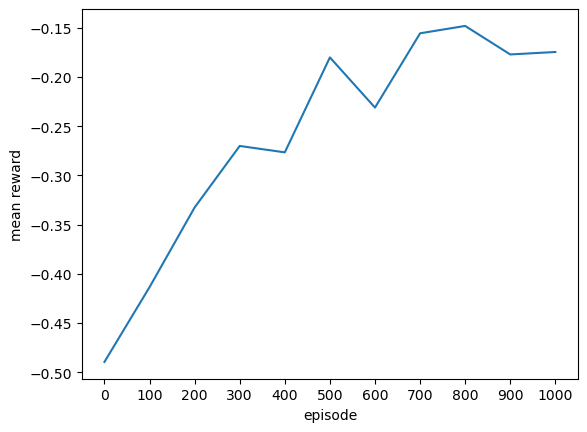

In [4]:
import numpy as np
from matplotlib import pyplot as plt

def automatic_game(env, q_values, n):
    reward = 0
    
    for i in range(n):
        terminated = False
        state = env.reset()
        
        while(not(terminated)):
            state, r, terminated = env.step(np.argmax(q_values[state[0]-1,state[1]-1, :]))
            reward += r
    
    return reward / n

env = BlackJackEnv()
learner1 = MonteCarlo(env)

rewards = []
q_values = learner1.learning(100)
rewards.append(automatic_game(env, q_values, 1000))

for i in range(10):
    q_values = learner1.learning(100, reset=False)
    rewards.append(automatic_game(env, q_values, 1000))

plt.plot(rewards)
plt.ylabel("mean reward")
plt.xlabel("episode")
plt.xticks(np.arange(11), np.arange(11)*100)
plt.show()


# Problem 2.2: Temporal Difference Learning (10 Points)

In this exercise, we use the frozen lake environment of the gymnasium framework to implement both temporal difference algorithms from the lecture. During the tasks, think about the following questions regarding the two algorithms. (You do not need to hand in answers to the questions, this is meant to guide your own understanding.)

- Which agent reaches the goal (terminal state) faster?
- How do the two methods differ with regard to the obtained returns?
- Which algorithm learns faster and why?

Hand in the final code of the whole exercise as well as a csv-file of the final state-action-values of each subtask.
**Make sure to include the environment name, number of episodes, and the update rule in the csv-file names.**

1. **(4 Points)** Read through the [documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) and 
   implement both the SARSA-Algorithms and the Q-Learning by Watkins in the provided TemporalDifference.py. Do not modify the function parameters and the returned values. 
   The base configuration of the agent for the experiments should be as follows:
   - $epsilon\_decay = 1.0$
   - $gamma = 1.0$ (the discount factor)
   - Initial Q-values $init\_value = 0.0$ and $alpha= 0.1$ (learning rate)
   Test your implementation with the frozen lake environment for 2000 episodes and give out the final state-action-values.
2. **(1 Point)** Run the test with the `is_slippery` parameter set to True. You may need to increase the number of
   episodes to 5000 to see the difference. Print out the state-action-values. Think about the results.
3. **(1 Point)** Set the size of the frozen lake environment to 8x8 with the `is_slippery` parameter set to False. Increase the number of
   episodes until you see a meaningful result in the state-action-values (This might not work). What are your thoughts on this? How could you improve the learning time?
4. **(2 Points)** Adjust your implementation so that it also works with the [cliff walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment.
   Test it with 200, 500, and 1000 episodes. Why is the progress for this environment faster? How do the best actions change with the increased number of episodes?
   Save the results of the 1000 episode test.
5. **(2 Points)** Add a visualization function which plots the final state next to the grid where the best directions are shown (see Figure below).
   Run the tests again and verify that the visualization works properly for all settings. Include one graphic for both the frozen lake and the cliff walking.
   *Hint: You can use the heatmap from the seaborn package with annotations.*

*Frozen Lake results with WatkinsQ and 2000 episodes.*
<p style="text-align:center;">
<img src="frozen.png" alt="Frozen Lake results with WatkinsQ and 2000 episodes" width="900">
</p>

## 2.2a: Temporal difference 

In [5]:
import numpy as np
import sys
import seaborn as sns
import matplotlib.animation
from matplotlib import pyplot as plt

class TDLearning:

    def __init__(self, env, env_name="frozenlake"):
        self.env = env
        self.env_name = env_name

    def e_greedy(self, state, epsilon):
        
        if (np.random.rand() < epsilon):
            action = self.env.action_space.sample()
        else:
            # Get optimal action from qvalues
            q_values = [self.action_states[state, a] for a in range(self.env.action_space.n)]
            action = np.argmax(q_values)
        
        return action
    
    def learning(self, episodes, update_rule='SARSA', alpha=1.0, gamma=1.0, init_value=0.0, epsilon=0.5, epsilon_decay=1.0):
        self.episodes = episodes
        self.update_rule = update_rule
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.action_states = np.zeros((self.env.observation_space.n, self.env.action_space.n)) + init_value

        if update_rule not in ['SARSA', 'WatkinsQ']:
            sys.exit('Unknown update_rule, use either \'SARSA\' or \'WatkinsQ\' !')
        
        trajectories = []
        
        for episode in range(episodes):
            
            s, _ = self.env.reset()
            a = self.e_greedy(s, self.epsilon)
            
            trajectory = []
        
            terminated = False
            truncated = False

            while not(terminated or truncated):

                _s, r, terminated, truncated, _ = self.env.step(a)
                
                if update_rule == 'SARSA':
                    _a = self.e_greedy(_s, self.epsilon)
                else:
                    _a = self.e_greedy(_s, 0)
                    
                self.action_states[s, a] += alpha * ( r + gamma * self.action_states[_s, _a] - self.action_states[s, a] )
                
                trajectory.append((s, a, r, _s))
                
                if update_rule == 'SARSA':              
                    a = _a
                else:
                    a = self.e_greedy(s, self.epsilon)

                s = _s

            # decay exploration rate
            self.epsilon *= self.epsilon_decay
            
            trajectories.append(trajectory)

        return self.action_states, trajectories
    
    def plot_q_values_map(self, map_size):
        """Plot the last frame of the simulation and the policy learned."""
        qtable_val_max, qtable_directions = self._qtable_directions_map(map_size)

        # Plot the last frame
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        ax[0].imshow(self.env.render())
        ax[0].axis("off")
        ax[0].set_title("Last frame")

        # Plot the policy
        sns.heatmap(
            qtable_val_max,
            annot=qtable_directions,
            fmt="",
            ax=ax[1],
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            xticklabels=[],
            yticklabels=[],
            annot_kws={"fontsize": "xx-large"},
        ).set(title="Learned Q-values\nArrows represent best action")
        for _, spine in ax[1].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.7)
            spine.set_color("black")
        img_title = f"{self.env_name}_{self.update_rule}_{self.episodes}_q_values_{map_size[0]}x{map_size[1]}.png"
        fig.savefig(img_title, bbox_inches="tight")
        plt.show()

    def _qtable_directions_map(self, map_size):
        """Get the best learned action & map it to arrows."""
        qtable_val_max = self.action_states.max(axis=1).reshape(map_size)
        qtable_best_action = np.argmax(self.action_states, axis=1).reshape(map_size)
        if self.env_name == "frozenlake":
            directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
        else:
            directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}
        qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
        eps = np.finfo(float).eps  # Minimum float number on the machine
        for idx, val in enumerate(qtable_best_action.flatten()):
            if qtable_val_max.flatten()[idx] > eps or qtable_val_max.flatten()[idx] < -eps:
                # Assign an arrow only if a minimal Q-value has been learned as best action
                # otherwise since 0 is a direction, it also gets mapped on the tiles where
                # it didn't actually learn anything
                qtable_directions[idx] = directions[val]
        qtable_directions = qtable_directions.reshape(map_size)
        return qtable_val_max, qtable_directions


## Run temporal difference

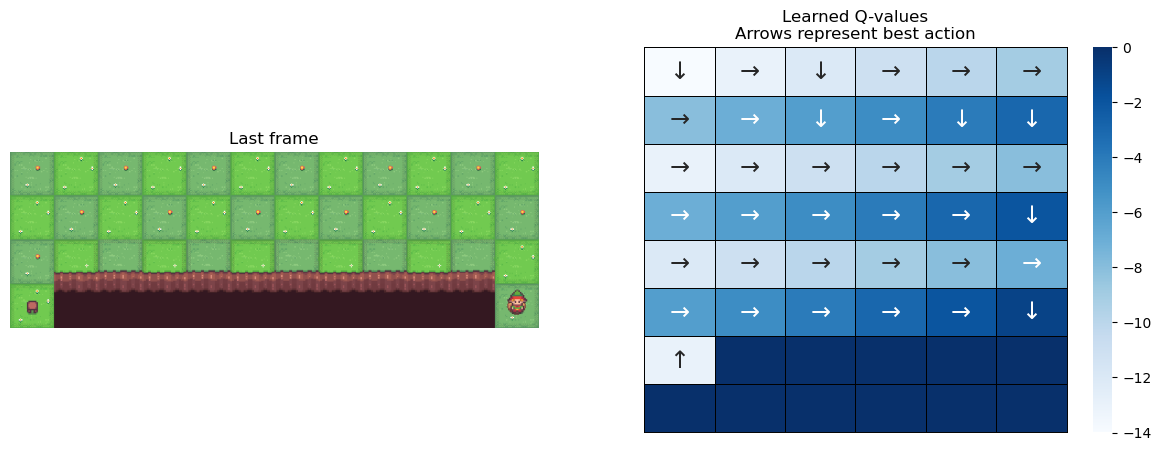

In [10]:
import numpy as np
import gymnasium as gym

# make environment with chosen options

#env = gym.make('FrozenLake-v1', render_mode="rgb_array", desc=None, map_name="4x4", is_slippery=False)
#learner = TDLearning(env)

env = gym.make('CliffWalking-v0', render_mode="rgb_array")
learner = TDLearning(env, "cliffwalking")

learner.learning(2000, "WatkinsQ",alpha=0.1)
learner.plot_q_values_map((8,6))

env.close()

---
Please upload your submission via StudIP by 20:00 on May 08, 2024. If you encounter any issues with the upload process, please contact me in advance at laux@uni-bremen.de.

Your submission must include: 
- All python files you created or modified for your submission
- A small .txt file with the names and e-mail addresses of the contributing team members

